In [1]:
import numpy as np
import os
import glob
import pandas as pd
import pickle
from sklearn.preprocessing import StandardScaler

In [2]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [3]:
cd drive/MyDrive/Colab\ Notebooks

/content/drive/MyDrive/Colab Notebooks


## All features for all basins without temporal aggregations with target Emiliani2 VHI

In [4]:
csv_noaggreg = "./allfeatures_noaggreg.csv"

In [5]:
all_features = pd.read_csv(csv_noaggreg).rename(columns={'Unnamed: 0': 'date'})

In [23]:
# merge with target values of Emiliani2
csv_target = "./csv/Emiliani2.csv"
target = pd.read_csv(csv_target).rename(columns={'Unnamed: 0': 'date'})

# remove dates not available in features
target = target[target['date'] <= all_features['date'].iloc[-1]]

target_df = pd.merge(all_features, target, on=['date'])['mean'].to_frame()

In [40]:
features_df = all_features.loc[:,all_features.columns.str.contains('cyclostationary')] 

## Regression with all temperature data, without years after 2019 (no final interval)

In [25]:
features_df = all_features.loc[:,all_features.columns.str.contains(r'^(?=.*cyclostationary)(?=.*tg)')] 

In [27]:
idx_dic = {}
for col in features_df.columns:
    idx_dic[col] = features_df.columns.get_loc(col)
print('\n'.join(f'{value}: {key}' for key, value in idx_dic.items()))

0: cyclostationary_mean_Adda_tg
1: cyclostationary_mean_Dora_tg
2: cyclostationary_mean_Emiliani1_tg
3: cyclostationary_mean_Piemonte_Sud_tg
4: cyclostationary_mean_Piemonte_Nord_tg
5: cyclostationary_mean_Oglio_Iseo_tg
6: cyclostationary_mean_Ticino_tg
7: cyclostationary_mean_Garda_Mincio_tg
8: cyclostationary_mean_Lambro_Olona_tg
9: cyclostationary_mean_Emiliani2_tg


In [28]:
scaler_f = StandardScaler()
scaler_t = StandardScaler()

In [ ]:
train_perc=0.42 # training data from 2001-01 to 2009-12 included
tot_rows = len(features_df)
# valid_perc = test_perc
valid_perc = 0.232 # validation data from 2010-01 to 2014-12 included, test until 2019-12 included

# 412 samples
features_train = features_df.iloc[0:int(tot_rows*train_perc)-1,:]
target_train = target_df.iloc[0:int(tot_rows*train_perc)-1,:]

# fit the scalers on training data
scaler_f.fit(features_train)
scaler_t.fit(target_train)

# scale all the dataset
features_df[features_df.columns] = scaler_f.transform(features_df[features_df.columns])
target_df[target_df.columns] = scaler_t.transform(target_df[target_df.columns])

X_train = features_df.iloc[0:int(tot_rows*train_perc)-1,:]
#228 samples for validation and for test
X_valid = features_df.iloc[int(tot_rows*train_perc)-1:int(tot_rows*(valid_perc+train_perc))]
X_test = features_df.iloc[int(tot_rows*(valid_perc+train_perc)):int(tot_rows*(valid_perc*2+train_perc))]

y_train = target_df.iloc[0:int(tot_rows*train_perc)-1,:]
y_valid = target_df.iloc[int(tot_rows*train_perc)-1:int(tot_rows*(valid_perc+train_perc))]
y_test = target_df.iloc[int(tot_rows*(valid_perc+train_perc)):int(tot_rows*(valid_perc*2+train_perc))]

X_train_valid = pd.concat([X_train, X_valid])
y_train_valid = pd.concat([y_train,y_valid])

In [32]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

reg = LinearRegression().fit(X_train_valid, y_train_valid)
print("R2_train: ", reg.score(X_train_valid, y_train_valid))
#print(mean_squared_error(y_train,reg.predict(X_train_all),squared=False))
print("R2_test: ", reg.score(X_test, y_test))
print("MAE: ", mean_absolute_error(y_test,reg.predict(X_test)))
print("MSE: ", mean_squared_error(y_test,reg.predict(X_test),squared=False))

R2_train:  0.14548231795865196
R2_test:  -0.005557125242000138
MAE:  0.6698414108938384
MSE:  0.8320436801287993


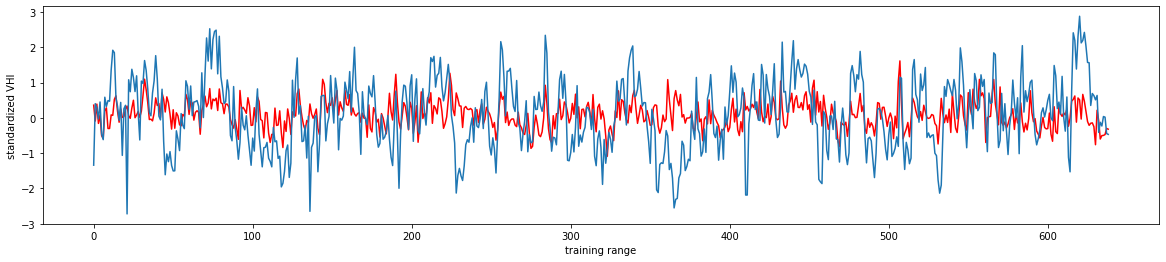

In [38]:
import matplotlib.pyplot as plt

reg = LinearRegression().fit(X_train_valid, y_train_valid)

# plot prediction on train
prediction = reg.predict(X_train_valid)

plt.plot(prediction, color='red')
plt.plot(y_train_valid)

plt.xlabel("training range")
plt.ylabel("standardized VHI")

plt.rcParams["figure.figsize"] = (20,4)

plt.show()
prediction = reg.predict(X_test)

plt.plot(prediction, color='red')
y_test.reset_index(drop = True, inplace = True)
plt.plot(y_test)

plt.xlabel("test range")
plt.ylabel("standardized VHI")

plt.rcParams["figure.figsize"] = (10,3)
plt.show()

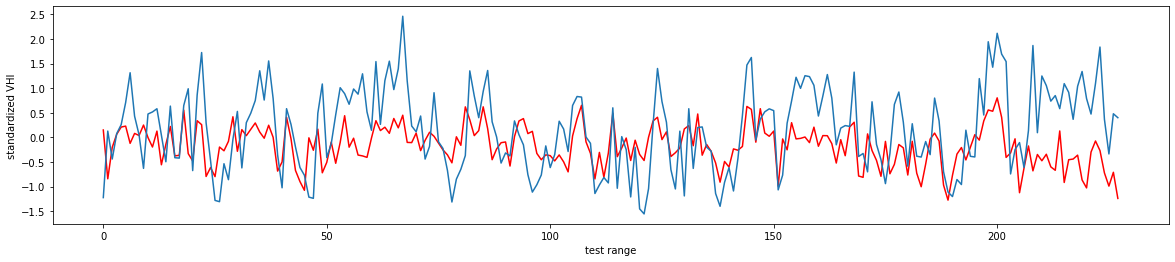

In [39]:
prediction = reg.predict(X_test)

plt.plot(prediction, color='red')
y_test.reset_index(drop = True, inplace = True)
plt.plot(y_test)

plt.xlabel("test range")
plt.ylabel("standardized VHI")

plt.rcParams["figure.figsize"] = (10,3)
plt.show()

# Feature Selection and linear regression

### Prepare pickle file for FS algorithm, with only the training set

In [42]:
# features selection done only on training set
n = 0.6

features_train = features_df.iloc[0:round(len(features_df)*n),:]
len(features_train)

589

In [43]:
target_train = target_df.iloc[0:round(len(target_df)*n),:]
len(features_train)

589

In [44]:
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features_train.values)
scaled_target = scaler.fit_transform(target_train.values)

In [ ]:
output = { "X" : scaled_features, "Y" : scaled_target}

with open("./pickles/targetEmiliani2.pickle", "wb") as f:
    pickle.dump(output, f)

### FS algorithm with different parameters values

#### k = 3

In [ ]:
# Delta: 0.0005, 0.005, 0.01 final number of features: 1, selected features IDs: [0]
# Delta: 0.05, 0.1 final number of features: 2, selected features IDs: [0, 13, 6]

%run "./scripts/main.py" --classification 0 --filename "./pickles/targetEmiliani2.pickle" --backward 'f' --k 3

#### k = 10

In [ ]:
# Delta: 0.005, 0.01, 0.05, 0.1 final number of features: 1, selected features IDs: [9] (Emiliani2_tg)
%run "./scripts/main.py" --classification 0 --filename "./pickles/targetEmiliani2.pickle" --backward 'f' --k 10

#### k = 40

In [ ]:
# Delta: 0.0005, final number of features: 1, selected features IDs: [9]
# Delta: 0.005, 0.01, 0.05, 0.1 final number of features: 2, selected features IDs: [9, 12, 2, 0]
%run "./scripts/main.py" --classification 0 --filename "./pickles/targetEmiliani2.pickle" --backward 'f' --k 40

#### k = 100

In [ ]:
# Delta: 0.005 final number of features: 1, selected features IDs: [3] (Piemonte_Sud_tg)
# Delta: 0.01, 0.05, 0.1 final number of features: 3, selected features IDs: [3, 12, 1]
%run "./scripts/main.py" --classification 0 --filename "./pickles/targetEmiliani2.pickle" --backward 'f' --k 100

## Linear Regression

In [47]:
scaler_f = StandardScaler()
scaler_t = StandardScaler()

# used split 80-20 for linear regression train and test

n = 0.8

features_train = features_df.iloc[0:round(len(features_df)*n),:]
target_train = target_df.iloc[0:round(len(target_df)*n),:]

features_test = features_df.iloc[round(len(features_df)*n):]
target_test = target_df.iloc[round(len(target_df)*n):]

# for training data fit and transform
scaled_features = pd.DataFrame(scaler_f.fit_transform(features_train.values), 
                               index=features_train.index, columns=features_train.columns)
scaled_target = pd.DataFrame(scaler_t.fit_transform(target_train.values), 
                             index=target_train.index, columns=target_train.columns)

scaled_test_features = pd.DataFrame(scaler_f.transform(features_test.values), 
                                    index=features_test.index, columns=features_test.columns)
scaled_test_target = pd.DataFrame(scaler_t.transform(target_test.values), 
                                    index=target_test.index, columns=target_test.columns)

In [48]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

# tutte le features
X_train_all = scaled_features
y_train = scaled_target

X_test_all = scaled_test_features
y_test = scaled_test_target

reg = LinearRegression().fit(X_train_all, y_train)
print("R2_train: ", reg.score(X_train_all, y_train))
#print(mean_squared_error(y_train,reg.predict(X_train_all),squared=False))
print("R2_test: ", reg.score(X_test_all, y_test))
print("MAE: ", mean_absolute_error(y_test,reg.predict(X_test_all)))
print("MSE: ", mean_squared_error(y_test,reg.predict(X_test_all),squared=False))
print('\n')

# delta piccolo
X_train = scaled_features.iloc[:,[9, 19]]
X_test = X_test_all.iloc[:,[9, 19]]
reg = LinearRegression().fit(X_train, y_train)
print("R2_train: ", reg.score(X_train, y_train))
print("R2_test: ", reg.score(X_test, y_test))
print("MSE: ", mean_squared_error(y_test,reg.predict(X_test),squared=False))
print('\n')

#bf: 2,3,6
# k medio, delta alto
X_train = scaled_features.iloc[:,[9, 12, 2, 0]]
X_test = X_test_all.iloc[:,[9, 12, 2, 0]]
reg = LinearRegression().fit(X_train, y_train)
print("R2_train: ", reg.score(X_train, y_train))
print("R2_test: ", reg.score(X_test, y_test))
print("MSE: ", mean_squared_error(y_test,reg.predict(X_test),squared=False))
print('\n')

# k alto, delta alto
X_train = scaled_features.iloc[:,[3, 12, 1]]
X_test = X_test_all.iloc[:,[3, 12, 1]]
reg = LinearRegression().fit(X_train, y_train)
print("R2_train: ", reg.score(X_train, y_train))
print("R2_test: ", reg.score(X_test, y_test))
print("MAE: ", mean_absolute_error(y_test,reg.predict(X_test)))
print("MSE: ", mean_squared_error(y_test,reg.predict(X_test),squared=False))

R2_train:  0.18552816321868604
R2_test:  0.03192403463030302
MAE:  0.8043995953852029
MSE:  0.9884473843873491


R2_train:  0.15425069350832976
R2_test:  0.045953172132569775
MSE:  0.9812590687402692


R2_train:  0.16548885673055214
R2_test:  0.038781431414954604
MSE:  0.9849403135496205


R2_train:  0.15988172121229138
R2_test:  0.07217902565867462
MAE:  0.7894515521385557
MSE:  0.9676781403525371


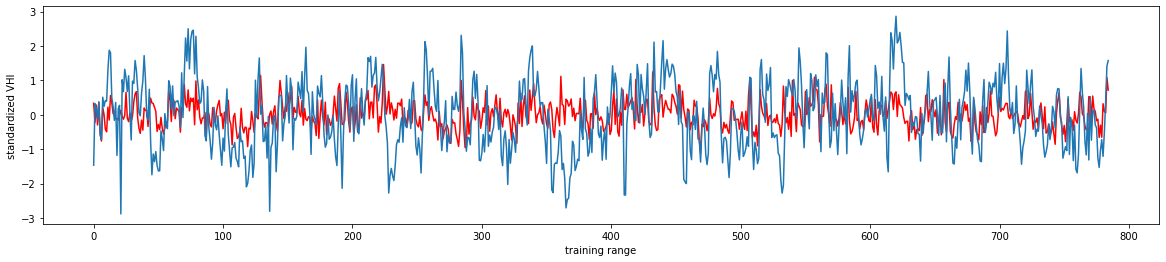

In [ ]:
import matplotlib.pyplot as plt

X_train = scaled_features.iloc[:,[3, 12, 1]]
reg = LinearRegression().fit(X_train, y_train)

# plot prediction on train
prediction = reg.predict(X_train)

plt.plot(prediction, color='red')
plt.plot(y_train)

plt.xlabel("training range")
plt.ylabel("standardized VHI")

plt.rcParams["figure.figsize"] = (20,4)

plt.show()

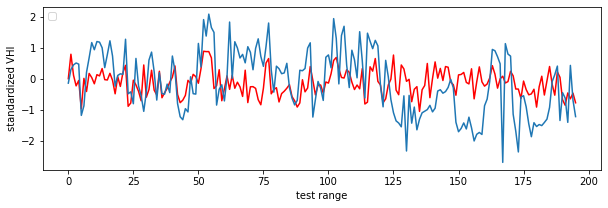

In [ ]:
# rispetto alla regressione sulla vecchia PCA segue un po' l'andamento del segnale reale
X_test = X_test_all.iloc[:,[3, 12, 1]]

prediction = reg.predict(X_test)

plt.plot(prediction, color='red')
y_test.reset_index(drop = True, inplace = True)
plt.plot(y_test)

plt.xlabel("test range")
plt.ylabel("standardized VHI")

plt.rcParams["figure.figsize"] = (10,3)
plt.show()

# Non linear models

## Imports and functions

In [ ]:
! pip install hypopt
! pip install tensorflow_addons
from sklearn.ensemble import ExtraTreesRegressor
from hypopt import GridSearch
from sklearn.metrics import mean_absolute_error, mean_squared_error
import tensorflow as tf
from tensorflow_addons.metrics import RSquare

In [ ]:
# only transform applied, for validation and test, scaler already fitted on training set before
def scaleValidTest(features, target, scaler_f, scaler_t):
    
    scaled_features = pd.DataFrame(scaler_f.transform(features.values), 
                                        index=features.index, columns=features.columns)
    scaled_target = pd.DataFrame(scaler_t.transform(target.values), 
                                    index=target.index, columns=target.columns)
    
    return scaled_features, scaled_target

In [ ]:
def feed_forward(num_units):
  # learning rate
  lr = 1e-3

  model = tf.keras.Sequential()
  model.add(tf.keras.layers.Dense(units=num_units, activation=tf.keras.activations.relu))
  model.add(tf.keras.layers.Dense(units = 1))

  metrics = [tf.keras.metrics.MeanAbsoluteError()]

  model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate = lr),
                loss='mse',
                metrics=metrics)
  
  return model

## With all features

In [ ]:
n = 0.6

features_train = features_df.iloc[0:round(len(features_df)*n),:]
target_train = target_df.iloc[0:round(len(target_df)*n),:]

# for training data fit and transform
scaled_train_features = pd.DataFrame(scaler_f.fit_transform(features_train.values), 
                               index=features_train.index, columns=features_train.columns)
scaled_train_target = pd.DataFrame(scaler_t.fit_transform(target_train.values), 
                             index=target_train.index, columns=target_train.columns)


features_valid = features_df.iloc[round(len(features_df)*n):round(len(features_df)*0.8),:]
target_valid = target_df.iloc[round(len(target_df)*n):round(len(target_df)*0.8),:]

features_test = features_df.iloc[round(len(features_df)*0.8):]
target_test = target_df.iloc[round(len(target_df)*0.8):]

scaled_valid_features, scaled_valid_target = scaleValidTest(features_valid, target_valid, scaler_f, scaler_t)
scaled_test_features, scaled_test_target = scaleValidTest(features_test, target_test, scaler_f, scaler_t)

###  ExtraTreeRegression

In [ ]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 30, stop = 120, num = 40)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
#max_depth = [int(x) for x in np.linspace(10, 110, num = 5)]
#max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 3, 4]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2]
# Method of selecting samples for training each tree
# bootstrap = [True]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               #'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               #'bootstrap': bootstrap
              }

In [ ]:
from sklearn.ensemble import ExtraTreesRegressor
from hypopt import GridSearch

extra = ExtraTreesRegressor()

opt = GridSearch(model = extra, param_grid = random_grid)

In [ ]:
opt.fit(scaled_train_features.values, scaled_train_target.values.ravel(), scaled_valid_features.values, 
        scaled_valid_target.values.ravel())

100%|██████████| 480/480 [00:49<00:00,  9.71it/s]


ExtraTreesRegressor(max_features='sqrt', min_samples_leaf=2, n_estimators=101,
                    random_state=0)

In [ ]:
train_valid_features = pd.concat([scaled_train_features,scaled_valid_features]).values
train_valid_target = pd.concat([scaled_train_target,scaled_valid_target]).values.ravel()

best_rf = opt.best_estimator_
best_rf.fit(train_valid_features, train_valid_target)

ExtraTreesRegressor(max_features='sqrt', min_samples_leaf=2, n_estimators=101,
                    random_state=0)

In [ ]:
rf_mae = mean_absolute_error(scaled_test_target.values.ravel(), best_rf.predict(scaled_test_features.values))
rf_mse = mean_squared_error(scaled_test_target.values.ravel(), best_rf.predict(scaled_test_features.values))
r2 = best_rf.score(scaled_test_features.values, scaled_test_target.values.ravel())

rf_mae, rf_mse, r2

(0.7941681782802257, 0.9145239727818374, 0.05593865932248476)

### Feed Forward

In [ ]:
train_valid_features = pd.concat([scaled_train_features,scaled_valid_features]).values
train_valid_target = pd.concat([scaled_train_target,scaled_valid_target]).values.ravel()

In [ ]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

ffnn_val = feed_forward(16)

hist_val = ffnn_val.fit(scaled_train_features.values, scaled_train_target.values, shuffle=False, epochs=100, 
                        validation_data=(scaled_valid_features.values, scaled_valid_target.values), callbacks=callback)

In [ ]:
ffnn = feed_forward(16)
ffnn.fit(train_valid_features, train_valid_target, shuffle=False, epochs=26)

In [ ]:
mean_absolute_error(scaled_test_target.values.ravel(), ffnn.predict(scaled_test_features.values))

7/7 [==============================] - 0s 2ms/step


0.786596297782816

In [ ]:
metric = RSquare()
metric.update_state(scaled_test_target.values, ffnn.predict(scaled_test_features.values))
r2 = metric.result()
r2.numpy()

7/7 [==============================] - 0s 2ms/step


0.02649331

## With chosen features

In [ ]:
# split in 20% for validation and 20% for test

n = 0.6

features_train = features_df.iloc[0:round(len(features_df)*n),[3, 12, 1]]
target_train = target_df.iloc[0:round(len(target_df)*n),:]

# for training data fit and transform
scaled_train_features = pd.DataFrame(scaler_f.fit_transform(features_train.values), 
                               index=features_train.index, columns=features_train.columns)
scaled_train_target = pd.DataFrame(scaler_t.fit_transform(target_train.values), 
                             index=target_train.index, columns=target_train.columns)


features_valid = features_df.iloc[round(len(features_df)*n):round(len(features_df)*0.8),[3, 12, 1]]
target_valid = target_df.iloc[round(len(target_df)*n):round(len(target_df)*0.8),:]

features_test = features_df.iloc[round(len(features_df)*0.8):,[3, 12, 1]]
target_test = target_df.iloc[round(len(target_df)*0.8):]

scaled_valid_features, scaled_valid_target = scaleValidTest(features_valid, target_valid, scaler_f, scaler_t)
scaled_test_features, scaled_test_target = scaleValidTest(features_test, target_test, scaler_f, scaler_t)

### ExtraTreeRegression

In [ ]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 30, stop = 180, num = 100)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
#max_depth = [int(x) for x in np.linspace(10, 110, num = 5)]
#max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 3, 5]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2]
# Method of selecting samples for training each tree
# bootstrap = [True]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
                'max_features': max_features,
               #'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               #'bootstrap': bootstrap
              }

In [ ]:
extra = ExtraTreesRegressor()

opt = GridSearch(model = extra, param_grid = random_grid)
opt.fit(scaled_train_features.values, scaled_train_target.values.ravel(), scaled_valid_features.values, 
        scaled_valid_target.values.ravel())

100%|██████████| 1200/1200 [02:53<00:00,  6.91it/s]


ExtraTreesRegressor(max_features='sqrt', min_samples_leaf=2, n_estimators=98,
                    random_state=0)

In [ ]:
best_rf = opt.best_estimator_
best_rf.fit(pd.concat([scaled_train_features,scaled_valid_features]).values, 
            pd.concat([scaled_train_target,scaled_valid_target]).values.ravel())

ExtraTreesRegressor(max_features='sqrt', min_samples_leaf=2, n_estimators=98,
                    random_state=0)

In [ ]:
rf_mae = mean_absolute_error(scaled_test_target.values.ravel(), best_rf.predict(scaled_test_features.values))
rf_mse = mean_squared_error(scaled_test_target.values.ravel(), best_rf.predict(scaled_test_features.values))
r2 = best_rf.score(scaled_test_features.values, scaled_test_target.values.ravel())

rf_mae, rf_mse, r2

(0.7941779197206925, 0.9145984020696234, 0.05586182611165136)

### Feed Forward

In [ ]:
train_valid_features = pd.concat([scaled_train_features,scaled_valid_features]).values
train_valid_target = pd.concat([scaled_train_target,scaled_valid_target]).values.ravel()

In [ ]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

ffnn_val = feed_forward(16)

hist_val = ffnn_val.fit(scaled_train_features.values, scaled_train_target.values, shuffle=False, epochs=150, 
                        validation_data=(scaled_valid_features.values, scaled_valid_target.values), callbacks=callback)

Epoch 1/150
19/19 [==============================] - 1s 11ms/step - loss: 1.7066 - mean_absolute_error: 1.0493 - val_loss: 1.4752 - val_mean_absolute_error: 0.9401
Epoch 2/150
19/19 [==============================] - 0s 4ms/step - loss: 1.3973 - mean_absolute_error: 0.9595 - val_loss: 1.1900 - val_mean_absolute_error: 0.8488
Epoch 3/150
19/19 [==============================] - 0s 4ms/step - loss: 1.1920 - mean_absolute_error: 0.8912 - val_loss: 0.9971 - val_mean_absolute_error: 0.7766
Epoch 4/150
19/19 [==============================] - 0s 4ms/step - loss: 1.0628 - mean_absolute_error: 0.8427 - val_loss: 0.8719 - val_mean_absolute_error: 0.7258
Epoch 5/150
19/19 [==============================] - 0s 4ms/step - loss: 0.9846 - mean_absolute_error: 0.8104 - val_loss: 0.7914 - val_mean_absolute_error: 0.6909
Epoch 6/150
19/19 [==============================] - 0s 4ms/step - loss: 0.9381 - mean_absolute_error: 0.7886 - val_loss: 0.7405 - val_mean_absolute_error: 0.6686
Epoch 7/150
19/19 [==

In [ ]:
ffnn = feed_forward(16)
ffnn.fit(train_valid_features, train_valid_target, shuffle=False, epochs=38)

Epoch 1/38
25/25 [==============================] - 0s 2ms/step - loss: 0.8444 - mean_absolute_error: 0.7360
Epoch 2/38
25/25 [==============================] - 0s 2ms/step - loss: 0.8347 - mean_absolute_error: 0.7306
Epoch 3/38
25/25 [==============================] - 0s 2ms/step - loss: 0.8300 - mean_absolute_error: 0.7285
Epoch 4/38
25/25 [==============================] - 0s 2ms/step - loss: 0.8268 - mean_absolute_error: 0.7270
Epoch 5/38
25/25 [==============================] - 0s 2ms/step - loss: 0.8242 - mean_absolute_error: 0.7259
Epoch 6/38
25/25 [==============================] - 0s 2ms/step - loss: 0.8221 - mean_absolute_error: 0.7251
Epoch 7/38
25/25 [==============================] - 0s 2ms/step - loss: 0.8204 - mean_absolute_error: 0.7244
Epoch 8/38
25/25 [==============================] - 0s 2ms/step - loss: 0.8189 - mean_absolute_error: 0.7237
Epoch 9/38
25/25 [==============================] - 0s 5ms/step - loss: 0.8178 - mean_absolute_error: 0.7232
Epoch 10/38
25/25 [

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

mean_absolute_error(scaled_test_target.values.ravel(), ffnn.predict(scaled_test_features.values))

7/7 [==============================] - 0s 2ms/step


0.7841035048176827

In [ ]:
from tensorflow_addons.metrics import RSquare

metric = RSquare()
metric.update_state(scaled_test_target.values, ffnn.predict(scaled_test_features.values))
r2 = metric.result()
r2.numpy()

7/7 [==============================] - 0s 3ms/step


0.059551954